# Queue-Based Aerosol Transmission Model - Figure Generation

This notebook generates all figures for the publication:
- **Figure 1**: Queue position dynamics with aerosol visualization
- **Figure 4A**: Numerical vs. analytical comparison
- **Figure 4B**: Exhaled particle concentration profiles
- **Figure 4C**: Particle concentration vs. normalized step time
- **Figure 4D**: Scaling analysis for optimal step duration
- **Figure 5**: Effect of total time and spatial separation

All computational functions are in `src/aerosol_functions.py`.
Computational data is saved to `data/figure_data.h5`.


In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py

# Import our functions
sys.path.insert(0, './src')
from aerosol_functions import (
    compute_results_multiple_a,
    compute_Q_over_Tss,
    exhaled,
    get_physical_constants,
    get_gauss_legendre_16,
    get_gauss_legendre_32,
    build_aerosol_field,
    compute_figure4A_data
)


In [31]:
# Configure matplotlib for publication-quality figures
mpl.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 30,
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
    "figure.titlesize": 30,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "svg.fonttype": "none",
    "mathtext.fontset": "dejavusans",
    "text.usetex": False,
})


In [7]:
# Physical constants
constants = get_physical_constants()
D = constants['D']      # Diffusion coefficient (m^2/s)
k = constants['k']      # Decay rate (1/s)
r0 = constants['r0']    # Characteristic length scale (m)

print(f"Physical constants:")
print(f"  D  = {D:.2e} m^2/s")
print(f"  k  = {k:.2e} 1/s")
print(f"  r0 = {r0:.2f} m")


Physical constants:
  D  = 3.80e-03 m^2/s
  k  = 9.00e-04 1/s
  r0 = 4.11 m


## Figure 1: Queue Position Dynamics with Aerosol Visualization

This figure visualizes the position of people in a queue over time with an aerosol particle field overlay.


In [8]:
# Parameters for Figure 1
t_step = 2.1        # waiting time per step
Delta  = 1.2         # spatial step
n_steps = 4          # number of moves
n_people = 3
initial_positions = [-n*Delta for n in range(n_people)]  # person 0 is exhaler
total_time = n_steps * t_step

# Worldlines setup (piecewise constant, instantaneous jump every t_step)
time_complete = []
for s in range(n_steps):
    time_complete.extend([s*t_step, (s+1)*t_step])
time_complete.append(n_steps * t_step)

positions = [[] for _ in range(n_people)]
for s in range(n_steps + 1):
    for p in range(n_people):
        y = initial_positions[p] + Delta * s
        if s < n_steps:
            positions[p].extend([y, y])
        else:
            positions[p].extend([y])

# Compute aerosol field
t_min, t_max = 0.01, total_time + 6.0
x_min = min(initial_positions) - 0.5
x_max = initial_positions[0] + Delta*n_steps + 2.0
Nt, Nx = 301, 301
x0_len = 0.01
dim = "3D"
power = 1.5 if dim == "3D" else 0.5

ts, xs, F = build_aerosol_field(t_min, t_max, Nt, x_min, x_max, Nx, 
                                x0_len, power, Delta, t_step, initial_positions[0])

print(f"Computed aerosol field: shape {F.shape}")


Computed aerosol field: shape (301, 301)


In [22]:
# plot figure 1
plt.rcParams['savefig.facecolor'] = 'none'
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_alpha(0)
ax.set_facecolor('none')

person_colors = plt.cm.plasma(np.linspace(0, 1, n_people)) # ['#FF6B6B', '#4ECDC4', '#45B8D1']
person_labels = ['Person 0 (sick, front)', 'Person 1', 'Person 2']

# plot worldlines
for p in range(n_people):
    ax.plot(time_complete, positions[p],
            color=person_colors[p], lw=3, marker='o', ms=6,
            label=person_labels[p])
    for s in range(1, n_steps + 1):
        t_jump = s * t_step
        x_old = initial_positions[p] + Delta * (s - 1)
        x_new = initial_positions[p] + Delta * s
        ax.plot([t_jump, t_jump], [x_old, x_new],
                color=person_colors[p], lw=2, ls='--', alpha=0.7)

ax.set_xlabel('Time $t$ [decay time]', fontsize=18)
ax.set_ylabel('Position $x$ [decay length]', fontsize=18)
# ax.set_title('Instantaneous exhaled field with moving emitter (purple gradient, transparent)', fontsize=14, pad=14)
ax.grid(True, alpha=0.25)
ax.set_xlim(-0.5, total_time + 0.5)
ax.set_ylim(min(initial_positions) - 0.5, 4)
ax.legend(fontsize=16, loc='upper left')

for s in range(n_steps + 1):
    ax.axvline(s*t_step, color='gray', ls=':', alpha=0.35)

# clip F
F = np.clip(F, 1e-2, F.max())

# Stronger separation of ~60 vs ~10 via power-law norm (gamma < 1)
purple_cmap = LinearSegmentedColormap.from_list("purple_gradient", ["#f2e5ff", "#4B0082"])
cmap = plt.cm.viridis
# norm        = PowerNorm(gamma=1, vmin=0.0, vmax=100.0)  # tweak gamma (0.45–0.7) as needed
norm        = LogNorm(vmin=F.min(), vmax=F.max())
gamma_alpha = 0.3
alpha_floor = 0.01
opacity_scale = 1.0



Fnorm = norm(F)                     # normalized [0,1]
rgba  = cmap(Fnorm)          # apply purple gradient
rgba[..., 3] = opacity_scale * (alpha_floor + (1.0 - alpha_floor) * (Fnorm ** gamma_alpha))
rgba[Fnorm <= 0.0] = (0, 0, 0, 0)
ax.imshow(rgba,
          extent=[ts.min(), ts.max(), xs.min(), xs.max()],
          origin='lower', aspect='auto', interpolation='auto',  # 'hanning' → use a valid method
          zorder=0)
# add colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
n_colors = 256
cmap_array = cmap(np.linspace(0, 1, n_colors))
# Compute the same alpha scaling as in the plot
Fnorm_lin = np.linspace(0, 1, n_colors)
cmap_array[:, 3] = opacity_scale * (alpha_floor + (1.0 - alpha_floor) * (Fnorm_lin ** gamma_alpha))
custom_cmap = mcolors.ListedColormap(cmap_array)

cb = plt.colorbar(ScalarMappable(norm=norm, cmap=custom_cmap), cax=cax)
cb.ax.tick_params(labelsize=16)
cb.set_label('Exhaled particles', fontsize=16)


# Add horizontal two-headed arrow at y=-1.2 from x=2 to x=4 with label t_step
arrow_y = - 2 * Delta
arrow_x_start = t_step
arrow_x_end = 2 * t_step
ax.annotate(
    '', 
    xy=(arrow_x_end, arrow_y), 
    xytext=(arrow_x_start, arrow_y),
    arrowprops=dict(arrowstyle='<->', color='k', lw=1.8),
    annotation_clip=False
)
ax.text(
    (arrow_x_start + arrow_x_end) / 2, 
    arrow_y - 0.18, 
    r'$t_\text{step}$', 
    ha='center', va='top', fontsize=18
)

# Add vertical two-headed arrow at x=4 from y=-2 to y=-1 with label Delta
arrow_x = 2 * t_step
arrow_y_start = -2 * Delta
arrow_y_end = -1 * Delta
ax.annotate(
    '', 
    xy=(arrow_x, arrow_y_end), 
    xytext=(arrow_x, arrow_y_start),
    arrowprops=dict(arrowstyle='<->', color='k', lw=1.8),
    annotation_clip=False
)
ax.text(
    arrow_x + 0.18,
    (arrow_y_start + arrow_y_end) / 2, 
    r'$\Delta$', 
    ha='center', va='top', fontsize=18
)

# Add vertical two-headed arrow at x=0 from y=0 to y=0.4 with label d
arrow_x = t_step - 0.1
arrow_y_start = Delta
arrow_y_end = 0.4 + Delta
ax.annotate(
    '', 
    xy=(arrow_x, arrow_y_end), 
    xytext=(arrow_x, arrow_y_start),
    arrowprops=dict(arrowstyle='<->', color='k', lw=1.8),
    annotation_clip=False
)
ax.text(
    arrow_x - 0.18,
    (arrow_y_start + arrow_y_end) / 2 + 0.1, 
    r'$d$', 
    ha='center', va='top', fontsize=18
)

# Add annotation in the bottom right with t_step and Delta values
ax.annotate(
    r"$t_\text{step}$ = " + f"{t_step}\n" + r"$\Delta$ = " + f"{Delta}",
    xy=(1.0, 0.0), xycoords='axes fraction',
    xytext=(-10, 10), textcoords='offset points',
    ha='right', va='bottom',
    fontsize=16,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
)

# Increase fontsize of the axes ticks' labels
ax.tick_params(axis='both', which='major', labelsize=16)

# Mark positions where the exhaler stands at the beginnings of steps (visual guide)
for s in range(n_steps+1):
    t0 = s * t_step
    x0 = initial_positions[0] + s * Delta + 0.4
    # ax.plot(t0, x0, 'ko', ms=7, mec='white', mew=1.5, alpha=0.95)

plt.tight_layout()
plt.savefig("figures/figure1.pdf", transparent=False)
plt.show()

## Figure 4A: Numerical vs. Analytical Comparison

This figure compares the numerical integration results with the analytical approximation.


In [34]:
# Compute and plot Figure 4A
print("Computing Figure 4A data...")

# Parameters
tss = np.logspace(0, 5, 120)  # dimensionless
T = 100
l = 100
eps = 1e-3
a_vals = np.logspace(-2, 1, 30)
k = 0.9e-3   # 1/s

# Compute data using function from aerosol_functions.py
Tss, numerical, analytical = compute_figure4A_data(tss, T, l, eps, a_vals, k)

# Plot
fig, ax = plt.subplots(figsize=(14, 9))

# Numerical integration
ax.semilogx(Tss, numerical, linewidth=3, 
            label=fr"Numerical Integration $\Delta$={l}")

# Analytical approximation
ax.semilogx(Tss, analytical, linewidth=3, 
            linestyle='--', label="Analytical Approximation", color='red')

ax.set_xlabel(r"$\tilde{t}_{\mathrm{step}}$", fontsize=40)
ax.set_ylabel("Particle Number", fontsize=40)
ax.set_xlim(1e-3, 1e4)
ax.legend(fontsize=14)
ax.set_xscale("log")
ax.set_xticks(10.0 ** np.arange(-2, 5))
ax.set_xticklabels([fr"$10^{{{n}}}$" for n in range(-2, 5)])



plt.tight_layout()
plt.savefig("figures/figure4A.pdf", bbox_inches="tight")
plt.show()
print("Figure 4A saved to figures/figure4A.pdf")


Computing Figure 4A data...


Figure 4A saved to figures/figure4A.pdf


## Figure 4B: Exhaled Particle Concentration Profiles

Shows spatial distribution of exhaled particles for different step durations.


In [26]:
# Parameters for Figure 4B
x0 = 0.1          # Source size scale (dimensionless)
gap = 1.3         # Spatial step size (dimensionless)
T = 40.0          # Total time (dimensionless)
Tsteps = [0.05, 0.10, 0.30]  # Step durations to plot
position = 9.1    # Observer position
d = 0.0           # Delay
sigma = 0.0       # Jitter
v = 0.0           # Velocity
dim = "3D"        # Dimension

# Spatial grid
x = np.linspace(0.0, position + 1.0, 10000)

# Compute exhaled profiles
profiles = {}
for Ts in Tsteps:
    p = exhaled(x0, x, Ts, gap, T, position, dim, d, sigma, v)
    profiles[Ts] = p
    print(f"Computed exhaled profile for Tstep = {Ts:.2f}")


Computed exhaled profile for Tstep = 0.05
Computed exhaled profile for Tstep = 0.10
Computed exhaled profile for Tstep = 0.30


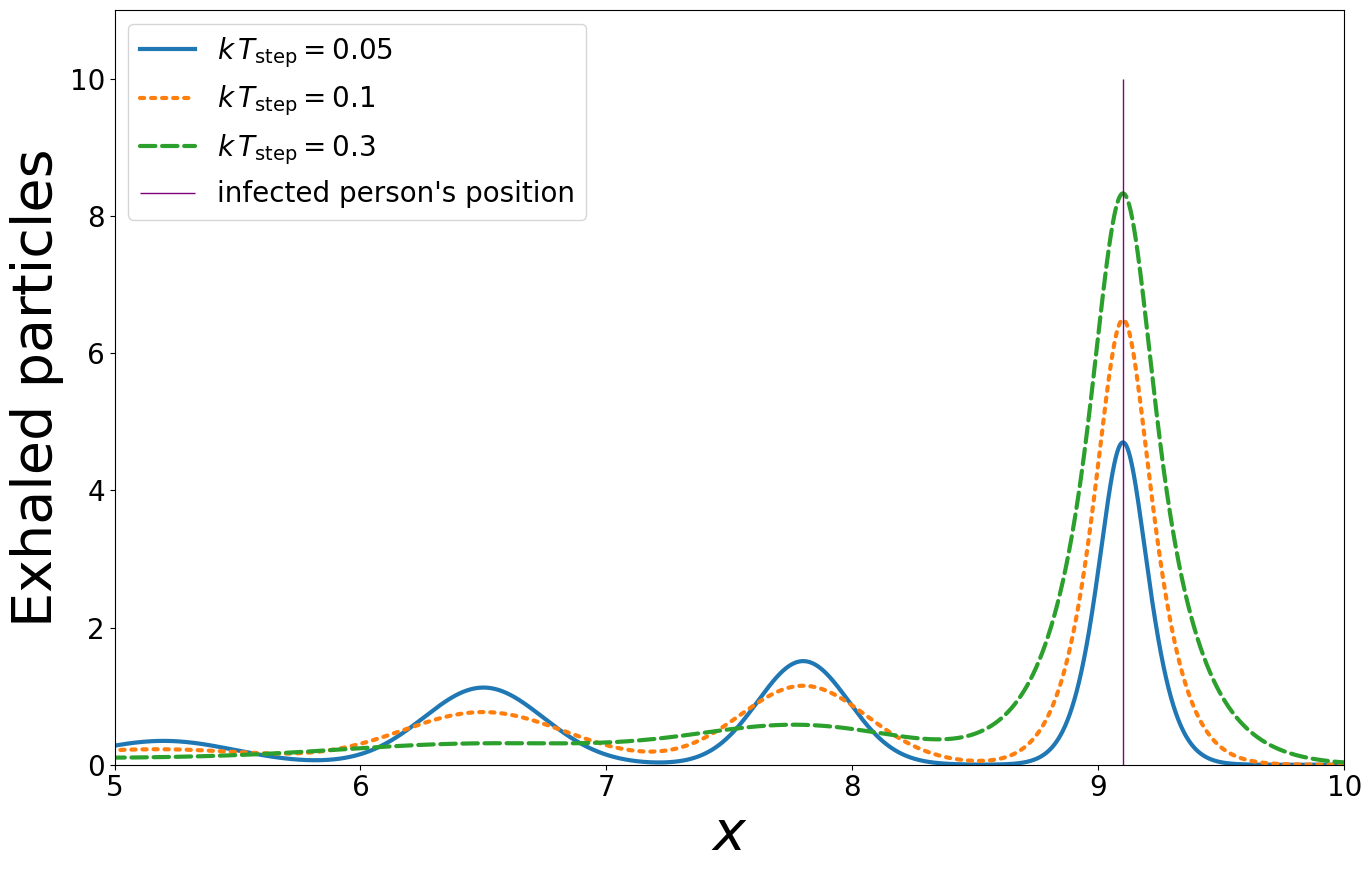

Figure 4B saved to figures/figure4B.pdf


In [35]:
# Plot Figure 4B
line_styles = ["-", ":", "--"]
marker_styles = ["", "", ""]

plt.figure(figsize=(14, 9))
for i, Ts in enumerate(Tsteps):
    plt.plot(x, profiles[Ts], linewidth=3, 
             linestyle=line_styles[i % len(line_styles)],
             marker=marker_styles[i % len(marker_styles)],
             markevery=30, dash_capstyle='round',
             label=fr"$k\,T_{{\rm step}}={Ts:g}$")

# Mark infected person's position
plt.vlines([position], ymin=0, ymax=10.0, color='purple', 
           linestyle='-', lw=1, label="infected person's position")

plt.legend(loc="upper left")
plt.xlabel(r"$x$", fontsize=40)
plt.ylabel("Exhaled particles", fontsize=40)
plt.xlim(5.0, 10)
plt.ylim(0.0, 11.0)
plt.tight_layout()
plt.savefig("figures/figure4B.pdf", dpi=300, bbox_inches="tight")
plt.show()

print("Figure 4B saved to figures/figure4B.pdf")


## Figure 4C: Particle Number vs. Normalized Step Time

Shows how total inhaled concentration varies with step duration for different forward distances.


In [29]:
# Parameters for Figure 4C
tss = np.logspace(0.0, 4.0, 100)  # 1 s ... 1e4 s
T = 100.0
Tss = k * tss  # Dimensionless step durations
l = 1.0        # Spatial step size (dimensionless)
eps = 1e-3
a_vals = np.array([0.05, 0.10, 0.30, 1], dtype=np.float64)

# Get Gauss-Legendre nodes and weights
glx16, glw16 = get_gauss_legendre_16()

# Compute results
result_ar = compute_results_multiple_a(
    Tss.astype(np.float64), a_vals, T, l, eps, glx16, glw16
)

print(f"Computed concentrations for {len(a_vals)} forward distances")
print(f"Result shape: {result_ar.shape}")


Computed concentrations for 4 forward distances
Result shape: (100, 4)


/var/folders/_q/pkqw9ws93pqcf4kd0t5qtnhh0000gn/T/ipykernel_21394/2339859077.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


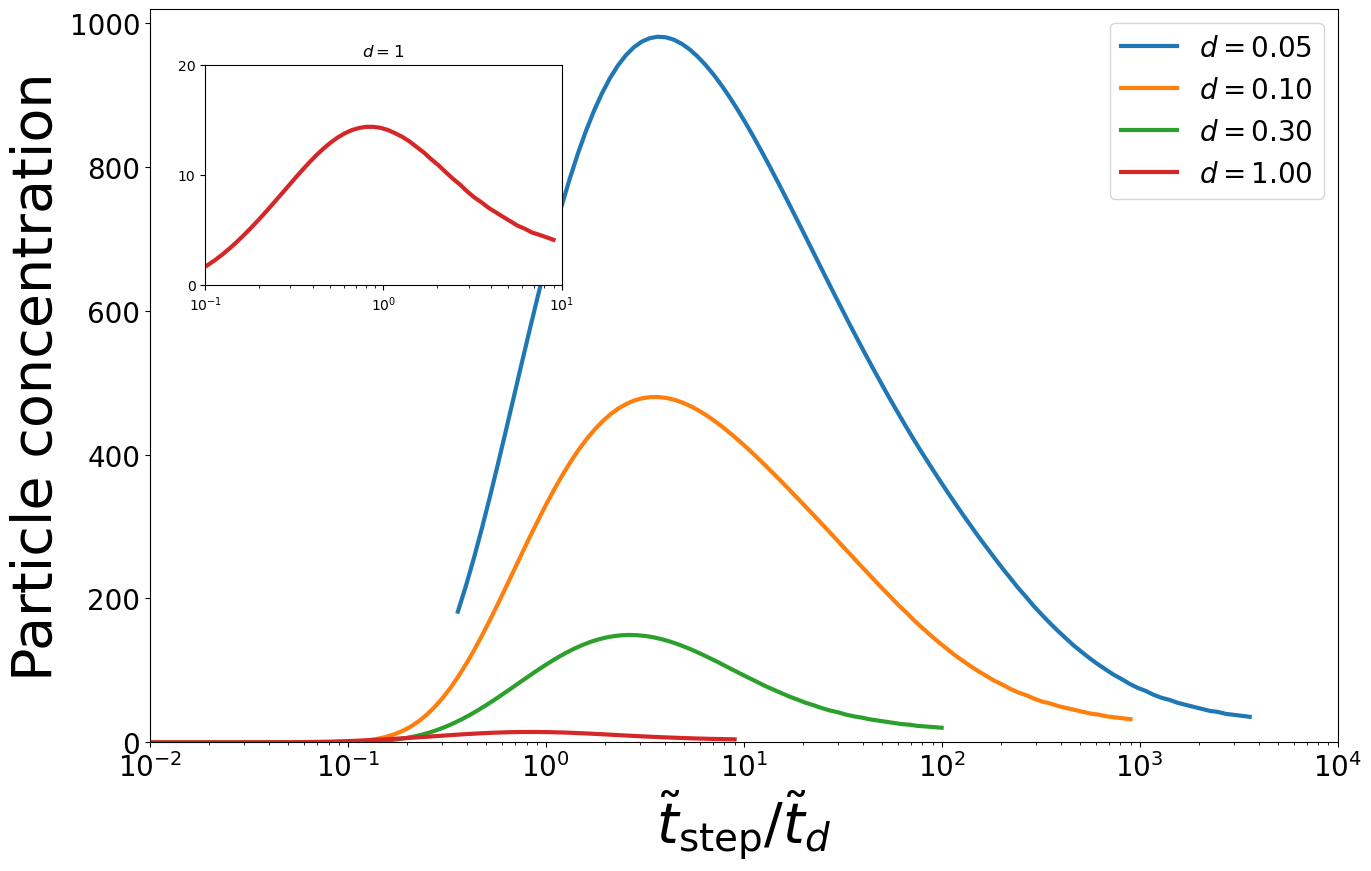

Figure 4C saved to figures/figure4C.pdf


In [30]:
# Plot Figure 4C with inset
fig = plt.figure(figsize=(14, 9))
ax = plt.gca()

for j, a in enumerate(a_vals):
    plt.semilogx(Tss / (a * a), result_ar[:, j], linewidth=3, 
                 label=fr"$d={a:.2f}$")

plt.xlabel(r"$\tilde{t}_{\mathrm{step}} / \tilde{t}_{d}$", fontsize=40)
plt.ylabel("Particle concentration", fontsize=40)
plt.xlim(1e-2, 1e4)
plt.ylim(0, 1020)
plt.legend()
plt.xticks(10.0 ** np.arange(-2, 5))
plt.gca().set_xticklabels([fr"$10^{{{n}}}$" for n in range(-2, 5)])

# Add inset for a=1 curve
a1_idx = np.where(a_vals == 1)[0][0]
inset_ax = inset_axes(ax, width="30%", height="30%", loc='upper left', borderpad=2)
inset_ax.semilogx(Tss / (a_vals[a1_idx] ** 2), result_ar[:, a1_idx], 
                  color='C3', linewidth=3)
inset_ax.set_ylim(0, 20)
inset_ax.set_xlim(1e-1, 1e1)
inset_ax.set_xticks([1e-1, 1e0, 1e1])
inset_ax.set_yticks([0, 10, 20])
inset_ax.tick_params(axis='both', which='major', labelsize=10)
inset_ax.set_title(r"$d=1$", fontsize=12)

plt.tight_layout()
plt.savefig("figures/figure4C.pdf", bbox_inches="tight") 
plt.show()

print("Figure 4C saved to figures/figure4C.pdf")


## Figure 4D: Scaling Analysis of Optimal Step Duration

Shows how the optimal step duration scales with forward distance for a large spatial separation.


In [38]:
# Parameters for Figure 4D
tss_fig5 = np.logspace(-2, 4, 300)
eps = 1e-4
a3 = np.logspace(np.log10(0.1), np.log10(10.0), 100)
T_fig5 = 30.0
M = 30  # Maximum image sources

A0 = 30.0  # Large spatial separation (main text case)
Tss_fig5 = k * tss_fig5

# Dimensionless parameters
as_dimless = a3 / r0
A = A0 / r0

# Find optimal step duration for each forward distance
tm = np.zeros(as_dimless.size, dtype=np.float64)

for l_idx, a_val in enumerate(as_dimless):
    Q = compute_Q_over_Tss(
        Tss_fig5.astype(np.float64), float(T_fig5), float(A),
        float(a_val), float(eps), glx16, glw16, M
    )
    idx = int(np.argmax(Q))
    tm[l_idx] = tss_fig5[idx]
    if (l_idx + 1) % 10 == 0:
        print(f"Processed {l_idx + 1}/{as_dimless.size} forward distances")

print(f"Computed optimal step durations for {len(as_dimless)} distances")


Processed 10/100 forward distances
Processed 20/100 forward distances
Processed 30/100 forward distances
Processed 40/100 forward distances
Processed 50/100 forward distances
Processed 60/100 forward distances
Processed 70/100 forward distances
Processed 80/100 forward distances
Processed 90/100 forward distances
Processed 100/100 forward distances
Computed optimal step durations for 100 distances


Scaling: t_step* ~ 3.54 * (a/r0)^2
Scaling: t_step* ~ 1.00 * (a/r0)^1


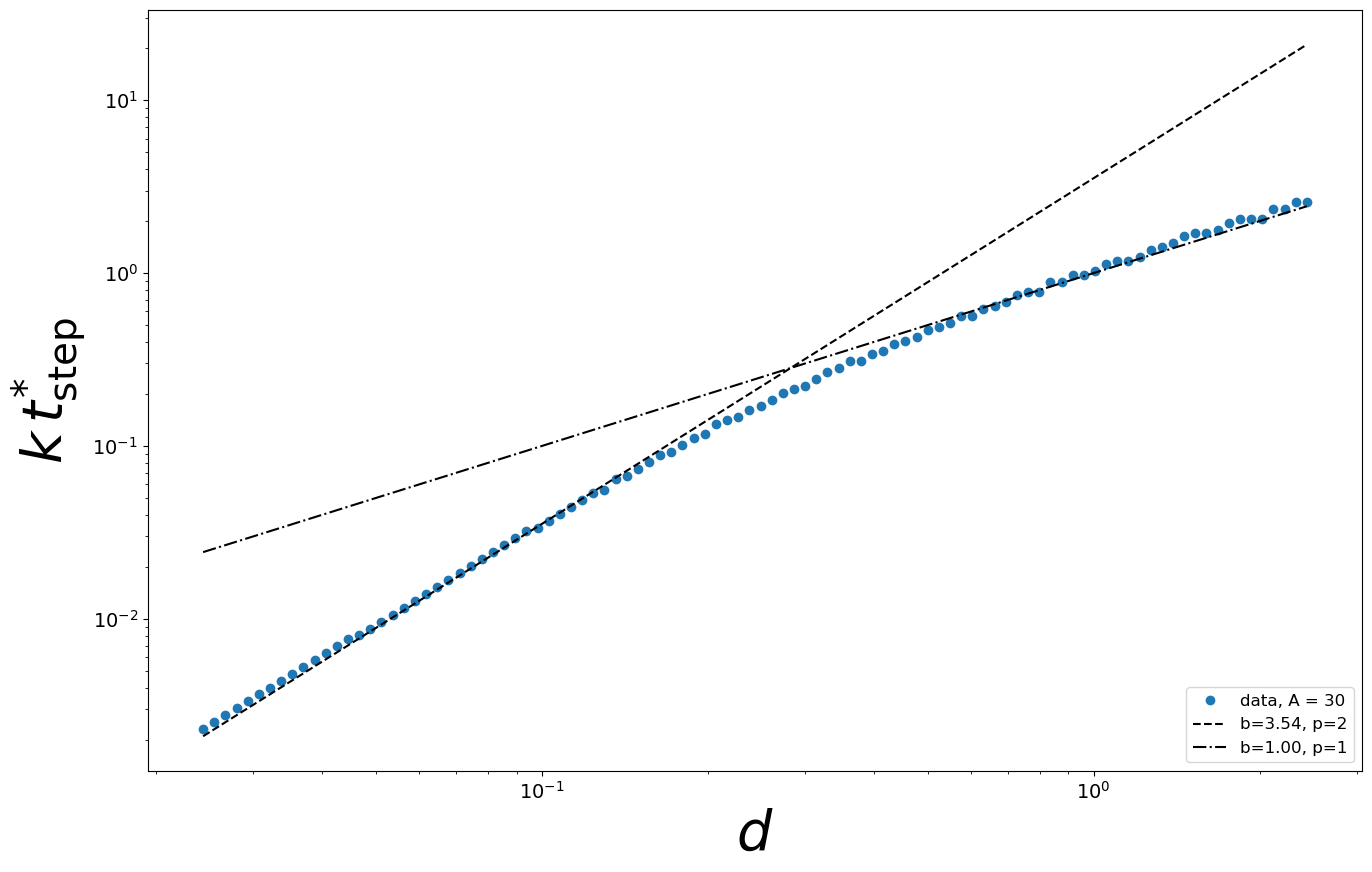

Figure 5 saved to figures/figure4D.pdf


In [40]:
# Plot Figure 4D
lims = np.array([0.25, 1.2], dtype=np.float64)

def _pow10_label(x, pos):
    if x <= 0:
        return ""
    e = np.log10(x)
    if abs(e - round(e)) < 1e-10:
        power = int(round(e))
        if power == -2:
            return ""
        return r"$10^{%d}$" % power
    return ""

plt.figure(figsize=(14, 9))
x_all = a3 / r0
y_all = k * tm

plt.loglog(x_all, y_all, 'o', label=f"data, A = {int(A0)}", color='C0')

# Fit scaling laws
range1 = a3 < lims[0]
range2 = a3 > lims[1]
powers = [2, 1]
ranges = [range1, range2]
linestyles = ['--', '-.']
coeffs = [3.54, 1.0]

for ip, (sel, p) in enumerate(zip(ranges, powers)):
    if not np.any(sel):
        continue
    xx = np.array(sorted(x_all))
    yy = coeffs[ip] * (xx ** p)
    plt.loglog(xx, coeffs[ip] * (xx ** p), linestyles[ip], color='k', 
               label=f'b={coeffs[ip]:.2f}, p={p}')
    print(f"Scaling: t_step* ~ {coeffs[ip]:.2f} * (a/r0)^{p}")

plt.xlabel(r"$d$", fontsize=40)
plt.ylabel(r"$k\,t_{\mathrm{step}}^{*}$", fontsize=40)
plt.tick_params(labelsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(_pow10_label))
plt.gca().xaxis.set_minor_formatter(mticker.NullFormatter())
plt.tight_layout()
plt.savefig("figures/figure4D.pdf", bbox_inches="tight") 
plt.show()

print("Figure 5 saved to figures/figure4D.pdf")


In [41]:
# Parameters for Figure 5
d_fig6 = 0.5  # m (forward distance)
l_fig6 = 2.0  # m (spatial separation)
tss_fig6 = np.logspace(0, 3, 120)
t_tot = np.array([2000, 4000, 6000, 8000, 10000], dtype=np.float64)

Tss_fig6 = k * tss_fig6
l_default = l_fig6 / r0
a_forward = d_fig6 / r0

eps_fig6 = 1e-3
M_fig6 = 100

# Part 1: Different total times
Ta = k * t_tot
res_T = np.zeros((Tss_fig6.size, Ta.size), dtype=np.float64)

for j, T_val in enumerate(Ta):
    res_T[:, j] = compute_Q_over_Tss(
        Tss_fig6.astype(np.float64), float(T_val), l_default,
        a_forward, eps_fig6, glx16, glw16, M_fig6
    )
    print(f"Computed for T = {T_val:g}")

# Part 2: Different spatial separation ratios
ratio = np.array([2.0, 4.0, 6.0, 8.0])
la = a_forward * ratio
T_fixed = float(Ta[-1])
res_l = np.zeros((Tss_fig6.size, la.size), dtype=np.float64)

for j, lval in enumerate(la):
    res_l[:, j] = compute_Q_over_Tss(
        Tss_fig6.astype(np.float64), T_fixed, float(lval),
        a_forward, eps_fig6, glx16, glw16, M_fig6
    )
    print(f"Computed for l/d ratio = {ratio[j]:.1f}")

print("All computations for Figure 6 complete")


Computed for T = 1.8
Computed for T = 3.6
Computed for T = 5.4
Computed for T = 7.2
Computed for T = 9
Computed for l/d ratio = 2.0
Computed for l/d ratio = 4.0
Computed for l/d ratio = 6.0
Computed for l/d ratio = 8.0
All computations for Figure 6 complete


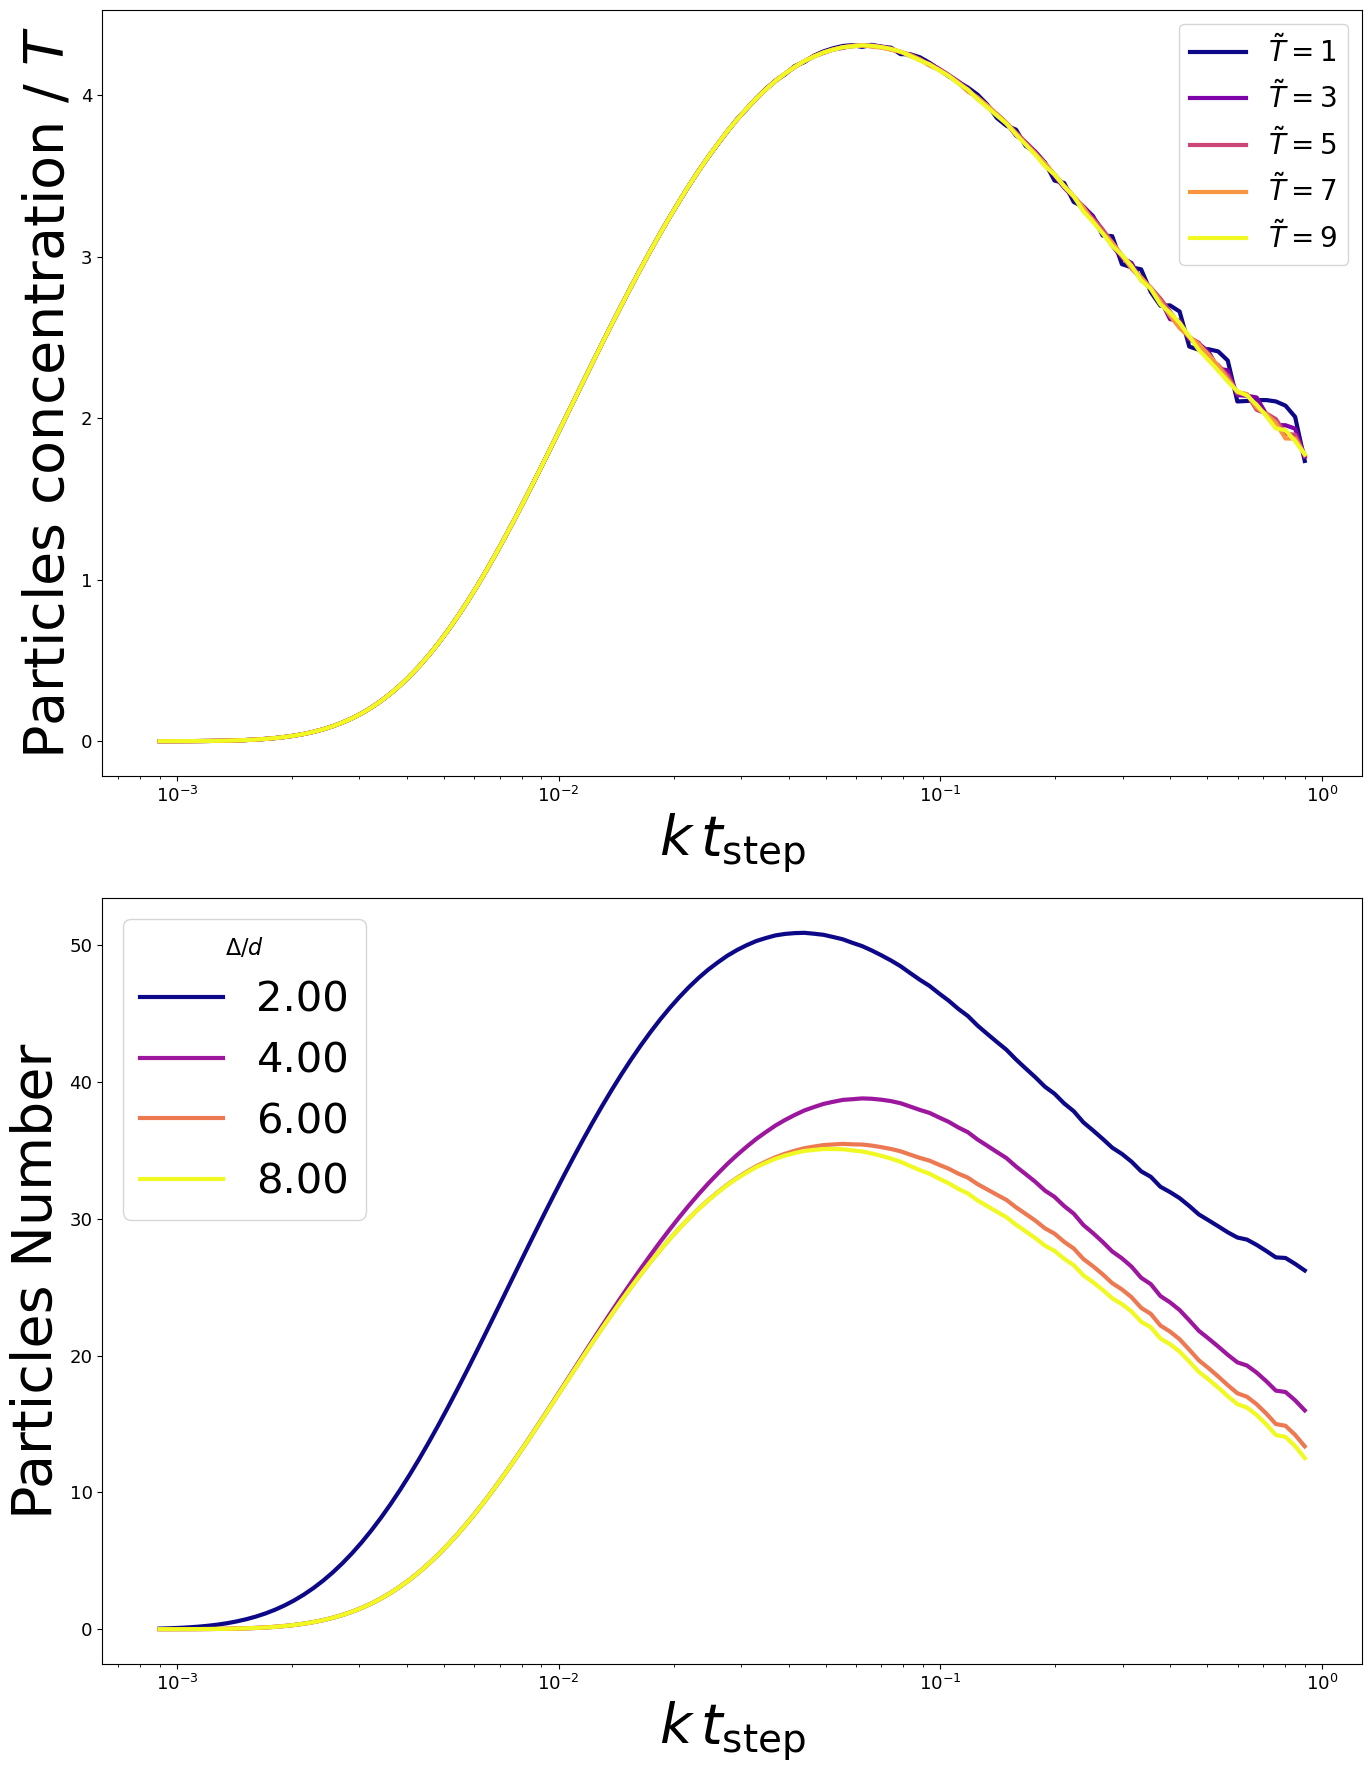

Figure 6 saved to figures/figure6.pdf


In [44]:
# Plot Figure 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 18))

# Top panel: Concentration/T vs step time
colors_T = plt.cm.plasma(np.linspace(0, 1, Ta.size))
for j, T_val in enumerate(Ta):
    ax1.semilogx(Tss_fig6, res_T[:, j] / T_val, color=colors_T[j], 
                 lw=3, label=r"$\tilde{T}=$" + f"{int(T_val)}")
ax1.set_xlabel(r"$k\,t_{\mathrm{step}}$", fontsize=40)
ax1.set_ylabel(r"Particles concentration / $T$", fontsize=40)
ax1.legend(fontsize=20)
ax1.tick_params(labelsize=13)

# Bottom panel: Concentration vs step time for different separations
colors_l = plt.cm.plasma(np.linspace(0, 1, la.size))
for j, lval in enumerate(la):
    ax2.semilogx(Tss_fig6, res_l[:, j], color=colors_l[j], 
                 lw=3, label=f'{ratio[j]:.2f}')
ax2.set_xlabel(r"$k\,t_{\mathrm{step}}$", fontsize=40)
ax2.set_ylabel(r"Particles Number", fontsize=40)
ax2.legend(title=r'$\Delta/d$', fontsize=30)
ax2.tick_params(labelsize=13)

plt.tight_layout()
plt.savefig("figures/figure6.pdf", bbox_inches="tight") 
plt.show()

print("Figure 6 saved to figures/figure6.pdf")


## Save Computational Data to HDF5

Save all computed data for reproducibility and future analysis.


In [46]:
# Save all data to HDF5
with h5py.File('data/figure_data.h5', 'w') as f:
    # Physical constants
    const_grp = f.create_group('physical_constants')
    const_grp.create_dataset('D', data=D)
    const_grp.create_dataset('k', data=k)
    const_grp.create_dataset('r0', data=r0)
    
    # Figure 1 data
    fig1_grp = f.create_group('figure_1')
    fig1_grp.create_dataset('ts', data=ts)
    fig1_grp.create_dataset('xs', data=xs)
    fig1_grp.create_dataset('F', data=F)
    fig1_grp.create_dataset('time_complete', data=time_complete)
    for p in range(n_people):
        fig1_grp.create_dataset(f'positions_person_{p}', data=positions[p])
    fig1_grp.attrs['t_step'] = t_step
    fig1_grp.attrs['Delta'] = Delta
    fig1_grp.attrs['n_steps'] = n_steps
    fig1_grp.attrs['n_people'] = n_people
    
    # Figure 4A data
    fig4a_grp = f.create_group('figure_4A')
    fig4a_grp.create_dataset('Tss', data=Tss)
    fig4a_grp.create_dataset('numerical', data=numerical)
    fig4a_grp.create_dataset('analytical', data=analytical)
    
    # Figure 4B data
    fig4b_grp = f.create_group('figure_4B')
    fig4b_grp.create_dataset('x_positions', data=x)
    fig4b_grp.create_dataset('Tsteps', data=Tsteps)
    for i, Ts in enumerate(Tsteps):
        fig4b_grp.create_dataset(f'profile_Ts_{Ts:.2f}', data=profiles[Ts])
    fig4b_grp.attrs['position'] = position
    fig4b_grp.attrs['gap'] = gap
    fig4b_grp.attrs['T'] = T
    
    # Figure 4C data
    fig4c_grp = f.create_group('figure_4C')
    fig4c_grp.create_dataset('tss', data=tss)
    fig4c_grp.create_dataset('Tss', data=Tss)
    fig4c_grp.create_dataset('a_vals', data=a_vals)
    fig4c_grp.create_dataset('result_array', data=result_ar)
    
    # Figure 4D data
    fig5_grp = f.create_group('figure_4D')
    fig5_grp.create_dataset('a3', data=a3)
    fig5_grp.create_dataset('optimal_tstep', data=tm)
    fig5_grp.attrs['A0'] = A0
    fig5_grp.attrs['T'] = T_fig5
    
    # Figure 5 data
    fig6_grp = f.create_group('figure_5')
    fig6_grp.create_dataset('tss', data=tss_fig6)
    fig6_grp.create_dataset('Tss', data=Tss_fig6)
    fig6_grp.create_dataset('t_tot', data=t_tot)
    fig6_grp.create_dataset('Ta', data=Ta)
    fig6_grp.create_dataset('results_T', data=res_T)
    fig6_grp.create_dataset('ratio', data=ratio)
    fig6_grp.create_dataset('results_l', data=res_l)
    fig6_grp.attrs['d'] = d_fig6
    fig6_grp.attrs['l'] = l_fig6

print("\nAll data saved to data/figure_data.h5")
print("\nData groups:")
with h5py.File('data/figure_data.h5', 'r') as f:
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  Dataset: {name} - shape {obj.shape}")
        elif isinstance(obj, h5py.Group):
            print(f"Group: {name}")
    f.visititems(print_structure)



All data saved to data/figure_data.h5

Data groups:
Group: figure_1
  Dataset: figure_1/F - shape (301, 301)
  Dataset: figure_1/positions_person_0 - shape (9,)
  Dataset: figure_1/positions_person_1 - shape (9,)
  Dataset: figure_1/positions_person_2 - shape (9,)
  Dataset: figure_1/time_complete - shape (9,)
  Dataset: figure_1/ts - shape (301,)
  Dataset: figure_1/xs - shape (301,)
Group: figure_4A
  Dataset: figure_4A/Tss - shape (120,)
  Dataset: figure_4A/analytical - shape (120,)
  Dataset: figure_4A/numerical - shape (120,)
Group: figure_4B
  Dataset: figure_4B/Tsteps - shape (3,)
  Dataset: figure_4B/profile_Ts_0.05 - shape (10000,)
  Dataset: figure_4B/profile_Ts_0.10 - shape (10000,)
  Dataset: figure_4B/profile_Ts_0.30 - shape (10000,)
  Dataset: figure_4B/x_positions - shape (10000,)
Group: figure_4C
  Dataset: figure_4C/Tss - shape (120,)
  Dataset: figure_4C/a_vals - shape (30,)
  Dataset: figure_4C/result_array - shape (100, 4)
  Dataset: figure_4C/tss - shape (120,)
G